###  UltraSonicSensorAnalysis Jupyter notebook - PyTorch version


#### Our goal is to predict the reflected (Echo) signal using other, more readily available, transducer parameters. 
#### We will use Frequency, Ring-down, and Excitation voltage to predict Echo signal amplitude. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.optim as optim


### Read in the data and create the training and test data sets

### Training and test data are selected randomly here, and could affect your results. 

In [58]:
# There are up to 10 measurements for each Die ID, and we need to keep these 10 measurements together so the 
# training and test sets have no cross-talk or "contamination".  In other words, 10 measurements for a given
# Die ID will all be either training or test measurements. 

# Here is the strategy:
# 1) Get all the unique Die IDs
# 2) Split the Die IDs into train IDs and test IDs
# 3) Create a test data frame from the test IDs and a train data frame from the train IDs

# First, read in the data from the "data" subfolder:
df = pd.read_csv('../data/test_data.csv')

# Here are all the unique Die IDs
die_ids = np.unique(df['Die ID'])
print("Unique Die IDs found:", len(die_ids))

# Here is the training fraction
train_frac = 0.75

# Now create a random list of the Die IDs to be used for training
train_ids = np.random.choice(die_ids, size=int(train_frac*len(die_ids)), replace=False)
print("Number of training Die IDs:", len(train_ids))

# Now here are the Die IDs to be used for testing - just get what wasn't used for training
test_ids = np.setdiff1d(die_ids, train_ids)
print("Number of testing Die IDs:", len(test_ids))
print()

# Confirm no training Die IDs are intermixed with testing Die IDs:
if (np.intersect1d(train_ids, test_ids, assume_unique=False, return_indices=False).size > 0):
    print("Testing and training Die IDs appear to be intermixed!!")
else:
    print("No crosstalk between training and testing Die IDs found.")

    
# Here, create the test and train data frames based on the Die IDs
test_df = pd.DataFrame()
train_df = pd.DataFrame()
junk = pd.DataFrame()

for tstid in test_ids:
    junk = df[ df['Die ID'] == tstid  ]
    #test_df = test_df.append(junk)
    test_df = pd.concat([test_df, junk], axis=0)

for trainid in train_ids:
    junk = df[ df['Die ID'] == trainid  ]
    #train_df = train_df.append(junk)
    train_df = pd.concat([train_df, junk], axis=0)
    
#print(test_df.shape, train_df.shape)
#print("Total number of rows:", train_df.shape[0] + test_df.shape[0])


# Split the train and test data into features (X) and labels (y):
X_train = train_df[['Frequency', 'Ring-down','Excitation']]
y_train = train_df['Echo']

X_test = test_df[['Frequency', 'Ring-down','Excitation']]
y_test = test_df['Echo']


# Not too critical in this case, but scale the features
scaler = MinMaxScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# OK, convert data to torch tensors
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Unique Die IDs found: 712
Number of training Die IDs: 534
Number of testing Die IDs: 178

No crosstalk between training and testing Die IDs found.


###  Define a very simple PyTorch neural network model with relu activation
#### Use same model topology, learning rate, batch size, epochs as was used for Keras notebook version

### Then, train model with batches inside the epoch loop

In [104]:
class simpleNN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 6)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(6, 9)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(9, 1, bias=True)
    
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x


model = simpleNN()
print(model)

loss_fn = nn.MSELoss() # Use MSE 
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Same as was used for Keras version

n_epochs = 250
batch_size = 64
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        X_train_batch = X_train[i:i+batch_size]
        y_pred = model(X_train_batch)
        y_train_batch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, y_train_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch % 10) == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')


simpleNN(
  (hidden1): Linear(in_features=3, out_features=6, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=6, out_features=9, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=9, out_features=1, bias=True)
)
Epoch: 0, Loss: 42999652.0
Epoch: 10, Loss: 40392436.0
Epoch: 20, Loss: 24624056.0
Epoch: 30, Loss: 6662149.5
Epoch: 40, Loss: 661246.125
Epoch: 50, Loss: 168801.40625
Epoch: 60, Loss: 141975.890625
Epoch: 70, Loss: 127370.921875
Epoch: 80, Loss: 110702.09375
Epoch: 90, Loss: 93527.8515625
Epoch: 100, Loss: 77798.2265625
Epoch: 110, Loss: 64912.98828125
Epoch: 120, Loss: 55354.96875
Epoch: 130, Loss: 48867.98046875
Epoch: 140, Loss: 44834.75390625
Epoch: 150, Loss: 42587.6171875
Epoch: 160, Loss: 41568.59765625
Epoch: 170, Loss: 41362.58203125
Epoch: 180, Loss: 41682.96484375
Epoch: 190, Loss: 42331.45703125
Epoch: 200, Loss: 43176.08984375
Epoch: 210, Loss: 44127.89453125
Epoch: 220, Loss: 45128.23828125
Epoch: 230, Loss: 46138.95703125
Epoch: 240, Loss: 471

### Using the test data set, test the model and see how it compares to the ground truth values

Slope: 0.895    Offset: 610.7


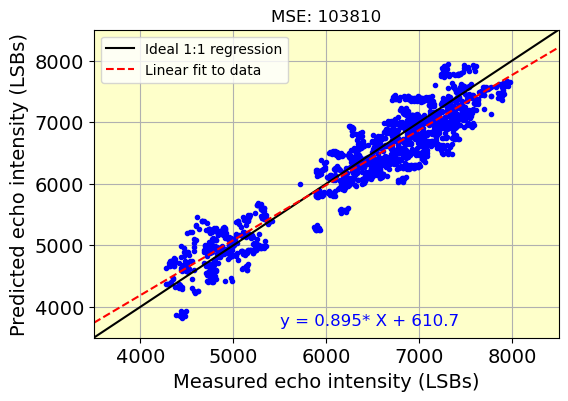

In [111]:
predictions = model(X_test)
predictions.shape, y_test.shape
mse = round(mean_squared_error(y_test.detach().numpy(), predictions.detach().numpy()) )

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

the_start = 3500
the_end = 8500

# Our predictions of the amplitude versus measured:
plt.plot(y_test.detach(), predictions.detach(), "b.")
plt.title(f'MSE: {mse}')

# Perfect prediction - a solid black line
plt.plot([the_start, the_end], [the_start, the_end],'k-', label="Ideal 1:1 regression")
plt.xlim(the_start, the_end)
plt.ylim(the_start, the_end)
ax = plt.gca()
ax.set_facecolor('#feffcA')
plt.grid()

plt.xlabel('Measured echo intensity (LSBs)', fontsize=14)
plt.ylabel('Predicted echo intensity (LSBs)', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)


lin_reg = LinearRegression()
lin_reg.fit(np.array(y_test.detach()).reshape(-1, 1), predictions.detach())

slope = np.round(lin_reg.coef_[0][0], 3)
intercept = np.round(lin_reg.intercept_[0], 1)

# Here are intercept and slope of predicted vs. actual amplitude values
print("Slope:", slope, "   Offset:",intercept)

# Plot linear fit of the predicted amplitude versus measured:
plt.plot([the_start, the_end],
         [the_start*lin_reg.coef_[0][0] + lin_reg.intercept_[0] , 
          the_end*lin_reg.coef_[0][0] + lin_reg.intercept_[0] ], 'r--', label="Linear fit to data")

# Show the best linear fit slope and intercept:
plt.text(the_start + 2000, the_start + 200, 'y = '+str(slope)+"* X + " + str(intercept), fontsize=12,color = (0, 0, 1));
plt.legend(loc='upper left');


### Train the model here

#### By default, we suppress output and shuffle the data. No need for GPU; the default model only takes several seconds to run. 

In [16]:
num_epochs = 250  # 250 works pretty well - may change if you change the model though!
batch_size = 64  # 64 works pretty well - may change if you change the model though!

model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=batch_size, epochs=num_epochs, shuffle=True, verbose=0) 

# Retain the model history
model_history = model.history.history

### Calculate the MSE and show the loss versus the epoch number

55/55 [==============================] - 0s 801us/step


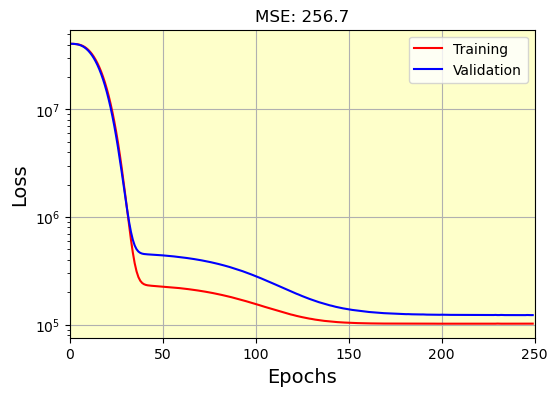

In [17]:
# Predict using the test features and compare to the actual
predictions = model.predict(X_test)
mse = mean_absolute_error(y_test, predictions)

save_fig = False

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

# Plot the model loss over the training epochs
losses = pd.DataFrame(model_history)
plt.semilogy(losses['loss'], 'r-', label='Training')
plt.semilogy(losses['val_loss'], 'b-', label='Validation')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title(f'MSE: {np.round(mse, 1)}')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
ax = plt.gca()

ax.set_facecolor('#feffcA')
plt.grid()
plt.xlim(0, num_epochs)
plt.legend();


if save_fig:
    fig = plt.gcf()
    fig_name = "Loss"
    fig.savefig("All_data" + fig_name)

### Finally, plot the predicted versus the ground truth Echo signal values as well as the best linear fit

55/55 [==============================] - 0s 785us/step
Slope: 0.87    Offset: 827.2


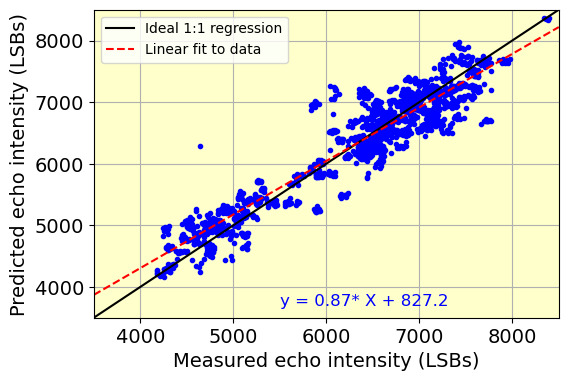

In [20]:
save_fig = False

fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)

the_start = 3500
the_end = 8500
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)

# Our predictions of the amplitude versus measured:
plt.plot(y_test, predictions, 'b.')

# Perfect prediction - a solid black line
plt.plot([the_start, the_end], [the_start, the_end],'k-', label="Ideal 1:1 regression")
plt.xlim(the_start, the_end)
plt.ylim(the_start, the_end)
ax = plt.gca()
ax.set_facecolor('#feffcA')
plt.grid()

plt.xlabel('Measured echo intensity (LSBs)', fontsize=14)
plt.ylabel('Predicted echo intensity (LSBs)', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

lin_reg = LinearRegression()
lin_reg.fit(np.array(y_test).reshape(-1, 1), predictions)

slope = np.round(lin_reg.coef_[0][0], 3)
intercept = np.round(lin_reg.intercept_[0], 1)

# Here are intercept and slope of predicted vs. actual amplitude values
print("Slope:", slope, "   Offset:",intercept)

# Plot linear fit of the predicted amplitude versus measured:
plt.plot([the_start, the_end],
         [the_start*lin_reg.coef_[0][0] + lin_reg.intercept_[0] , 
          the_end*lin_reg.coef_[0][0] + lin_reg.intercept_[0] ], 'r--', label="Linear fit to data")

# Show the best linear fit slope and intercept:
plt.text(the_start + 2000, the_start + 200, 'y = '+str(slope)+"* X + " + str(intercept), fontsize=12,color = (0, 0, 1));
plt.legend(loc='upper left')

if save_fig:
    fig = plt.gcf()
    fig_name = "test"
    fig.savefig("test" + fig_name)

In [19]:
# Coefficient of determination - R^2
y_train_preds = model.predict(X_train)
train_r2 = r2_score(np.array(y_train).reshape(-1, 1), y_train_preds)
test_r2 = r2_score(np.array(y_test).reshape(-1, 1), predictions)

print(train_r2, test_r2)

163/163 [==============================] - 0s 783us/step
0.9003570326015076 0.8747810583627864


In [62]:
type(mse)

numpy.float32